# Setup


In [ ]:
!unzip Nazari_Jamshid_Product.zip

In [ ]:
!cd keras-retinanet && pip3 install .  


Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=129119 sha256=09f6408f32d745dcc9ca4f6395db501a19d88bc2f0d9b031a7a4df5d0961ea4c
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=b20c45968f25075e1ffe56ad27dc864a0ec71070735ecc05ffcd31f64e36b3d3
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
!cd keras-retinanet &&  python3 setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
building 'keras_retinanet.utils.compute_overlap' extension
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.o
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                

# Libraries and preprocess 
run this first

In [ ]:
##This will run slow on CPU and low end GPUs##
import keras
import numpy as np
import cv2
from PIL import Image
from keras_retinanet import models
from keras_retinanet.utils.gpu import setup_gpu
setup_gpu(0)

#Load model
path = '/content/drive/My Drive/model_both_dataset.h5'

model = models.load_model(path)

##Preprocess function
import keras.applications.imagenet_utils
from keras_retinanet.utils.image import resize_image
def preprocess(frame):
    window = frame.copy()  # make a copy to draw on, original will be passed into the CNN
    frame = keras.applications.imagenet_utils.preprocess_input(frame)
    frame, scale = resize_image(frame)
    return window,frame,scale


1 Physical GPUs, 1 Logical GPUs
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
     

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Testing one image




Inference time for one image: 0.0799


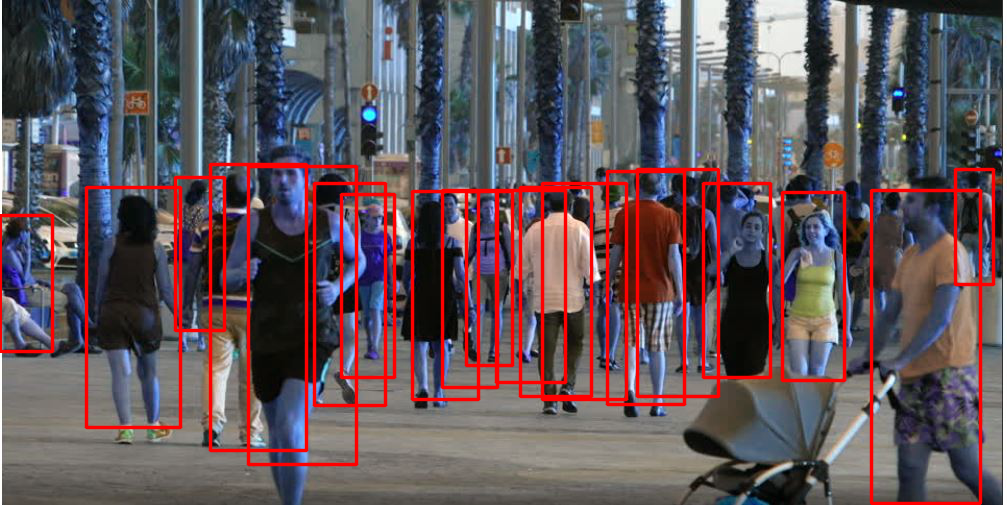

In [ ]:
from keras_retinanet.utils.visualization import draw_box
from google.colab.patches import cv2_imshow
import time 

frame = Image.open('8.jpg')
frame = np.asarray(frame)
window, frame,scale = preprocess(frame)

initialTime = time.time() # start timer before model
bb,scores,labels = model.predict_on_batch(np.expand_dims(frame, axis=0))
endTime = time.time() - initialTime # end timer after model 

print('Inference time for one image: {:.4f}'.format( endTime))

# scale the bonuding to origal image scales.
bb/=scale

for bb,score in zip(bb[0],scores[0]):
    if score < 0.5: # threshold
        break
    draw_box(window, bb.astype(int), color=[0,0,255])

cv2_imshow(window)


# Video Input

In [ ]:
from keras_retinanet.utils.visualization import draw_box
# INPUT = '/content/raw_video.mp4'
INPUT = '/content/video_0313.mp4'
OUTPUT= 'video_0313_inferred.avi'

cap = cv2.VideoCapture(INPUT)
width = cap.get(3) # 3 for width
height = cap.get(4) # 4 for height

writer = cv2.VideoWriter(OUTPUT,cv2.VideoWriter_fourcc(*'MJPG'),20,frameSize=(int(width),int(height)))
print('Processing video')
while(cap.isOpened()):
    ret, frame = cap.read()
    # copy to draw on
    if not ret:
        break;

    window, frame,scale = preprocess(frame)
    
    boxes, scores,labels = model.predict(np.expand_dims(frame, axis=0)) # add new axis to image and pass to CNN
    #adjust to scale
    boxes /= scale
    for box, score in zip(boxes[0], scores[0]):
        # scores are sorted so we can break
        if score < 0.4:
            break
        #draw bounding box on the image from keras-retinanet library
        draw_box(window, box.astype(int), color=[0,0,255])
    writer.write(window)
        
print('done.. saved :'+ OUTPUT)
cap.release()
cv2.destroyAllWindows()
    


Processing video
done.. saved :video_0313_inferred.avi


# Test datasets

In [ ]:
!wget http://www.vision.caltech.edu/Datasets/CRP/annotations.pkl

--2020-04-15 14:57:14--  http://www.vision.caltech.edu/Datasets/CRP/annotations.pkl
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71640185 (68M) [binary/octet-stream]
Saving to: ‘annotations.pkl’

annotations.pkl     100%[===================>]  68.32M  6.45MB/s    in 38s     

2020-04-15 14:57:53 (1.82 MB/s) - ‘annotations.pkl’ saved [71640185/71640185]



In [ ]:
import pickle
import pandas as pd
import os

with open('annotations.pkl','rb') as file:
    caltech_data = pickle.load(file, encoding='latin1')
print(len(caltech_data))

BASE_CALTECH_PATH ='.'

7


In [ ]:
#validation Dataset
import pandas as pd
import os
val_df = pd.DataFrame(columns=['file_path', 'x1', 'y1', 'x2', 'y2', 'class_name'])

val_folders = ['2012-08-25-RoseBowl', '2012-09-20-RoseBowl']

for video in val_folders:
    print(video)
    frames = caltech_data[video]['images']['path']
    frame_list = list(frames)
    
    for frame in frame_list:
        # load annotation for each frame
        for annotation  in (caltech_data[video]['frame annotations'][frame]):
            #get boundiing box of the frame
            bounding_box = annotation['bounding box']
            
            # make sure there is a bounding box in the annotation
            if(len(bounding_box) > 0):
                x,y,w,h = bounding_box['x'],bounding_box['y'],bounding_box['width'],bounding_box['height']
                
                frame_dir = os.path.join(BASE_CALTECH_PATH,frames[frame]);

                #print({'file_path':frames[frame],'x1':x,'y1':y,'x2':x+w,'y2':y+h,'class_name':'person'})
                
                #create the dataset annotation in the desired format
                val_df = val_df.append([{'file_path':os.path.join(BASE_CALTECH_PATH,frames[frame]),'x1':int(x),'y1':int(y),'x2':int(x+w),'y2':int(y+h),'class_name':'person'}],ignore_index=True);

#write the annotation to csv file.
val_df.to_csv('val_samples.csv',index=False,header=False);

2012-08-25-RoseBowl
2012-09-20-RoseBowl


In [ ]:
!7z x /content/drive/My\ Drive/Colab\ Notebooks/Images.7z  -o*

# Evaluating the mAP score and average processing time 
The mAP score for the COCO only model, before it was trained on the caltech dataset

In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.utils.eval import evaluate
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
setup_gpu(0)

path = 'model_only_coco.h5'

coco_only_model = models.load_model(path)

generator = CSVGenerator('val_samples.csv','class.csv')
precisions, times = evaluate(generator,coco_only_model)

print(precisions.get(0)) # 0 for person

print('Inference time for {:.0f} images: {:.4f}'.format(generator.size(), times))

print('mAP: {:.4f}'.format(precisions.get(0)[0]))

1 Physical GPUs, 1 Logical GPUs
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
     

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
Running network: 100% (7623 of 7623) |###| Elapsed Time: 0:18:10 Time:  0:18:10
Parsing annotations: 100% (7623 of 7623) || Elapsed Time: 0:00:00 Time:  0:00:00


(0.7838146234021155, 13135.0)
Inference time for 7623 images: 0.0745
mAP: 0.7838


# mAP score for COCO and Caltech pedestrian trained model 
This is before it was trained on COCO and then on the caltech dataset

In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.utils.eval import evaluate
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
setup_gpu(0)

path = 'model_both_dataset.h5'

model = models.load_model(path)

generator = CSVGenerator('val_samples.csv','class.csv')
precisions, times = evaluate(generator,model)

print(precisions.get(0)) # 0 for person

print('Inference time for {:.0f} images: {:.4f}'.format(generator.size(), times))

print('mAP: {:.4f}'.format(precisions.get(0)[0]))


1 Physical GPUs, 1 Logical GPUs
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
     

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
Running network: 100% (7623 of 7623) |###| Elapsed Time: 0:17:55 Time:  0:17:55
Parsing annotations: 100% (7623 of 7623) || Elapsed Time: 0:00:00 Time:  0:00:00


(0.8547041205897636, 13135.0)
Inference time for 7623 images: 0.0733
mAP: 0.8547
